In [ ]:
### 檢查GPU
!nvidia-smi

Fri Aug 14 14:52:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    60W / 149W |  10621MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title 下載資料集和預訓練模型 (大約兩分鐘)
from IPython.display import clear_output
!git clone https://github.com/AI-FREE-Team/Kaggle_dog-and-cat.git
!apt-get install unrar
!unrar x '/content/Kaggle_dog-and-cat/cat_dog_classifier.part01.rar'
clear_output(wait=True)
print("下載完成!")

下載完成!


In [ ]:
#@title 解壓縮資料
import zipfile
zip_files = ['train.zip', 'test1.zip']

for zip_file in zip_files:
    with zipfile.ZipFile("/content/{}".format(zip_file),"r") as z:
        z.extractall("/content/")
        print("{} unzipped".format(zip_file))

train.zip unzipped
test1.zip unzipped


## Data_Processing

In [ ]:
#@title 載入相關套件

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os

import warnings

warnings.filterwarnings('ignore')

In [ ]:
#@title 把train資料夾內的東西放進列表裡

IMAGE_FOLDER_PATH=r"/content/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
# FILE_NAMES = []
# for i in glob.glob(IMAGE_FOLDER_PATH):
#   FILE_NAMES.append(i)
  # print(i)
WIDTH=150
HEIGHT=150
FILE_NAMES

['dog.10661.jpg',
 'dog.747.jpg',
 'dog.6875.jpg',
 'cat.3322.jpg',
 'dog.7271.jpg',
 'cat.12134.jpg',
 'cat.6246.jpg',
 'cat.6418.jpg',
 'cat.1055.jpg',
 'cat.10413.jpg',
 'dog.6542.jpg',
 'dog.4900.jpg',
 'dog.6021.jpg',
 'dog.1828.jpg',
 'cat.3943.jpg',
 'dog.11204.jpg',
 'dog.11913.jpg',
 'cat.1574.jpg',
 'cat.7196.jpg',
 'dog.6983.jpg',
 'cat.4323.jpg',
 'dog.7075.jpg',
 'cat.1583.jpg',
 'dog.6294.jpg',
 'cat.7301.jpg',
 'dog.7737.jpg',
 'dog.1773.jpg',
 'cat.4496.jpg',
 'dog.628.jpg',
 'dog.11649.jpg',
 'dog.7370.jpg',
 'cat.7815.jpg',
 'cat.8934.jpg',
 'cat.10067.jpg',
 'dog.11130.jpg',
 'cat.1686.jpg',
 'dog.1797.jpg',
 'dog.8986.jpg',
 'cat.2079.jpg',
 'cat.3728.jpg',
 'cat.742.jpg',
 'dog.10463.jpg',
 'dog.4397.jpg',
 'dog.2783.jpg',
 'cat.10294.jpg',
 'cat.4834.jpg',
 'dog.7871.jpg',
 'dog.10388.jpg',
 'dog.2085.jpg',
 'dog.2241.jpg',
 'dog.11341.jpg',
 'cat.6491.jpg',
 'cat.11224.jpg',
 'cat.11304.jpg',
 'dog.11651.jpg',
 'dog.4888.jpg',
 'cat.10253.jpg',
 'dog.845.jpg',
 '

In [ ]:
#@title 將圖片的讀取路徑製作成Pandas表格 (包含標準答案label)

targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    # target=file_name.split("train/")[1].split(".")[0]
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['label']=targets

In [ ]:
dataset

,image_path,label
0,/content/train/dog.10661.jpg,dog
1,/content/train/dog.747.jpg,dog
2,/content/train/dog.6875.jpg,dog
3,/content/train/cat.3322.jpg,cat
4,/content/train/dog.7271.jpg,dog
...,...,...
24995,/content/train/cat.12376.jpg,cat
24996,/content/train/cat.1240.jpg,cat
24997,/content/train/cat.9715.jpg,cat
24998,/content/train/cat.4816.jpg,cat


In [ ]:
#@title 計算有多少隻貓與狗在train資料集裡

target_counts=dataset['label'].value_counts()
print("Number of dogs in the dataset:{}".format(target_counts['dog']))
print("Number of cats in the dataset:{}".format(target_counts['cat']))

Number of dogs in the dataset:12500
Number of cats in the dataset:12500


## <font color=#ffd700>【HW】model部分</font>

<img src="https://i.imgur.com/J4WEtxs.jpg">
<img src="https://i.imgur.com/Vjg5Lrj.jpg">



In [ ]:
model=models.Sequential()
model.add(layers.Conv2D(48, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))  # WIDTH、HEIGHT = 150
model.add(layers.Conv2D(48, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary() #查看模型

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 48)      1344      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 146, 146, 48)      20784     
_________________________________________________________________
batch_normalization_8 (Batch (None, 146, 146, 48)      192       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 73, 73, 48)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 73, 73, 48)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 71, 71, 64)        27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 69, 69, 64)       

### <font color=#ffd700>【HW】 調整優化器、損失函數以及要觀察的評估指標</font>

In [ ]:
#@title 選擇要使用的優化器
Optimizer = 'Adam' #@param ["SGD", "RMSprop","Adam"]
# if Optimizer == 'SGD':
#   Opti = optimizers.SGD(lr=0.001)
# elif Optimizer == 'RMSprop':
#   Opti = optimizers.RMSprop
# elif Optimizer == 'Adam':
#   Opti = optimizers.Adam
model.compile(loss="binary_crossentropy", 
             optimizer=Optimizer,
             metrics=["accuracy"])
print("[INFO]: model compiled...")
print(f'optimizer : {Optimizer}')
from keras.callbacks import ModelCheckpoint
callback = [ModelCheckpoint(
    filepath = '/content/my_model.h5', 
    save_best_only=True, 
)]

[INFO]: model compiled...
optimizer : Adam


In [ ]:
### 切割資料集，分成訓練集與驗證集
dataset_train, dataset_valid=train_test_split(dataset,
                                                 test_size=0.2,
                                                 random_state=42)
print(f'訓練集資料數 : {len(dataset_train)}')
print(f'驗證集資料數 : {len(dataset_valid)}')

訓練集資料數 : 20000
驗證集資料數 : 5000


In [ ]:
#@title 訓練集預處理
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="label",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
#@title 驗證集也做一樣的事情

test_datagen=ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_valid,
                                                   x_col="image_path",
                                                   y_col="label",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


### <font color=#ffd700>【HW】 開始訓練</font>
※ 可調整參數 epoch(訓練次數)-訓練愈久模型效度越好

In [ ]:
# 開始training

modelHistory1=model.fit_generator(train_datagenerator,
                                epochs=5,
                                validation_data=test_datagenerator,
                                # validation_steps=dataset_valid.shape[0]/150,
                                # steps_per_epoch=dataset_train.shape[0]/150,
                                callbacks = callback,
                                )

Epoch 1/5
134/134 [==============================] - 206s 2s/step - loss: 0.7858 - accuracy: 0.5898 - val_loss: 1.2934 - val_accuracy: 0.5046
Epoch 2/5
134/134 [==============================] - 203s 2s/step - loss: 0.6089 - accuracy: 0.6719 - val_loss: 1.0908 - val_accuracy: 0.5046
Epoch 3/5
134/134 [==============================] - 204s 2s/step - loss: 0.5576 - accuracy: 0.7149 - val_loss: 0.8759 - val_accuracy: 0.5184
Epoch 4/5
134/134 [==============================] - 205s 2s/step - loss: 0.5283 - accuracy: 0.7408 - val_loss: 1.1478 - val_accuracy: 0.5560
Epoch 5/5
134/134 [==============================] - 206s 2s/step - loss: 0.4839 - accuracy: 0.7707 - val_loss: 0.5792 - val_accuracy: 0.7094


Train Accuracy:0.771
Valid Accuracy:0.709


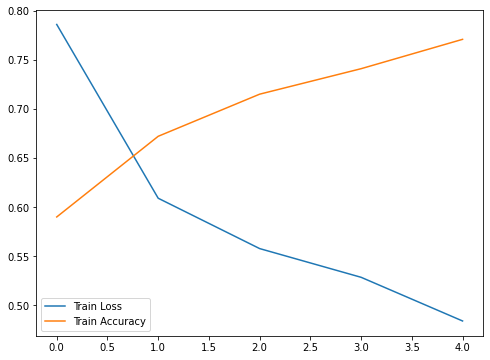

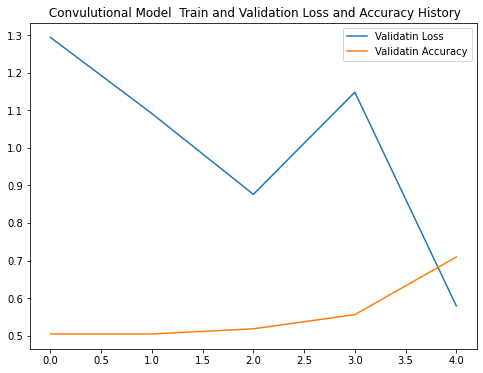

In [ ]:
#@title 顯示訓練結果 參考loss(損失)跟accuracy(準確性) (兩張圖)

def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history_valid = pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history_valid["Validatin Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history_valid["Validatin Accuracy"]=modelHistory.history['val_accuracy']

    history.plot(figsize=(8,6))
    plt.show()
    history_valid.plot(figsize=(8,6))
    plt.title(" Convulutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()


print("Train Accuracy:{:.3f}".format(modelHistory1.history['accuracy'][-1]))
print("Valid Accuracy:{:.3f}".format(modelHistory1.history['val_accuracy'][-1]))
show_model_history(modelHistory=modelHistory1, model_name="")

## Transfer learning

In [ ]:
#@title 載入以訓練好的pre-trained model或是用自己訓練好的模型
model_type = 'own-model' #@param ["own-model", "pre-trained"]
from keras.models import load_model
if model_type == 'pre-trained':
  model=applications.VGG16(weights="imagenet", include_top=False, input_shape=(WIDTH, HEIGHT, 3))
  print('你使用的是AI-FreeTeam的pre-trained Model')
else:
  model = load_model('my_model.h5')
  print('你正在使用自己設計的Model')
model.summary()

你正在使用自己設計的Model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 48)      1344      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 146, 146, 48)      20784     
_________________________________________________________________
batch_normalization_8 (Batch (None, 146, 146, 48)      192       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 73, 73, 48)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 73, 73, 48)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 71, 71, 64)        27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 69

## 測試你的自己上傳的照片!!

Saving cat1.jpg to cat1 (2).jpg


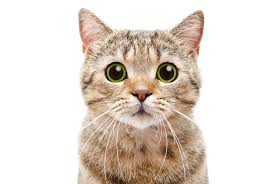

In [ ]:
#@title 從本機端(你自己的電腦的資料夾) 選擇要上傳的圖片
from google.colab import files
uploaded = files.upload()

from google.colab.patches import cv2_imshow
x = ''
for i in uploaded:
  x = i
predict_img = '/content/' + x
img = load_img(predict_img, target_size=(WIDTH, HEIGHT))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
feature=model.predict(img)
feature = feature.reshape(1,-1)
import cv2
ig = cv2.imread(predict_img,1)
cv2_imshow(ig)

In [ ]:
#@title 預測結果
import pickle
if model_type == 'pre-trained':
  with open('/content/Kaggle_dog-and-cat/clf.pickle', 'rb') as f:
      clf2 = pickle.load(f)
      # predict = model.predict(feature.reshape(1,-1))
      y_pred=clf2.predict(feature)
      # print('模型判斷結果 : ',y_pred)
  if y_pred == 1:
    print('This is a dog.')
  else:
    print('This is a cat.')
else:
  if feature > 0.8:
    print('This is a dog.')
  else:
    print('This is a cat.')

NameError: ignored